In [1]:
#!pip install pydicom

- Descargar el archivo que contiene los archivos TAC (https://short.upm.es/3u5s7) y subirlo a Colab.

In [2]:
#!unzip ct_scans.zip

# <span style="color:pink"> AUTORES </span>
 
* **<span style="color:pink"> Sebastián Kay Conde Lorenzo </span>**
* **<span style="color:pink"> Francisco Manuel López López </span>**

# <span style="color:red">¿DÓNDE ENCONTRAR LAS IMÁGENES, NOTAS Y DEMÁS?</span>

**<span style="color:red">PARA ENCONTRAR EL PROYECTO COMPLETO DE ESTOS NOTEBOOKS (INCLUYENDO LA ESTRUCTURA DE CARPETAS E IMÁGENES USADAS) POR FAVOR VISITAR ESTE [REPOSITORIO](https://github.com/cbasitodx/Image_Processing_Course)**</span>

In [3]:
import numpy as np
import pandas as pd
import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import glob

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Working directory
input_folder = './imagenes/ct_scans/'
patients = glob.glob(os.path.join(input_folder, '*.dcm'))
patients.sort()

In [4]:
# Load the scans in given folder path
def load_scan(files):
    slices = [dicom.dcmread(f) for f in files]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness

    return slices

In [5]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0

    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):

        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope

        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)

        image[slice_number] += np.int16(intercept)

    return np.array(image, dtype=np.int16)


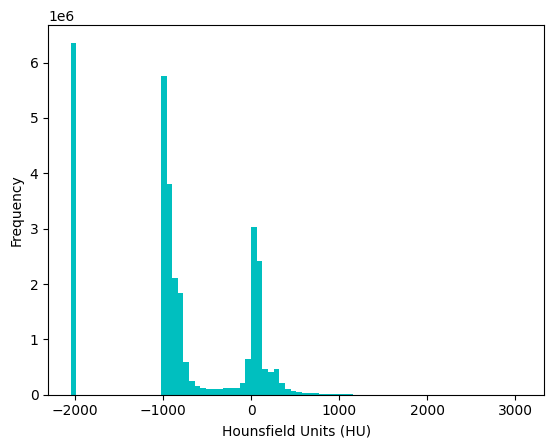

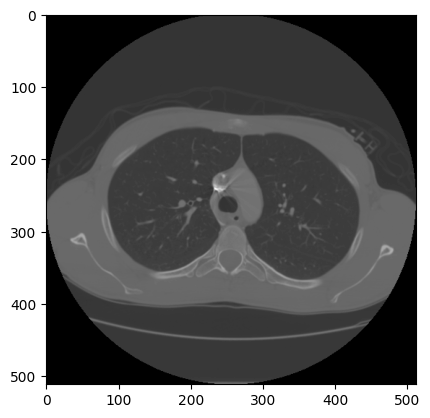

In [6]:
first_patient = load_scan(patients)
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

In [7]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    image = scipy.ndimage.zoom(image, real_resize_factor, mode='nearest')

    return image, new_spacing

In [8]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (114, 512, 512)
Shape after resampling	 (285, 340, 340)


In [9]:
def plot_3d(image, threshold=-300):

    # Position the scan upright,
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)

    verts, faces, normals, values = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

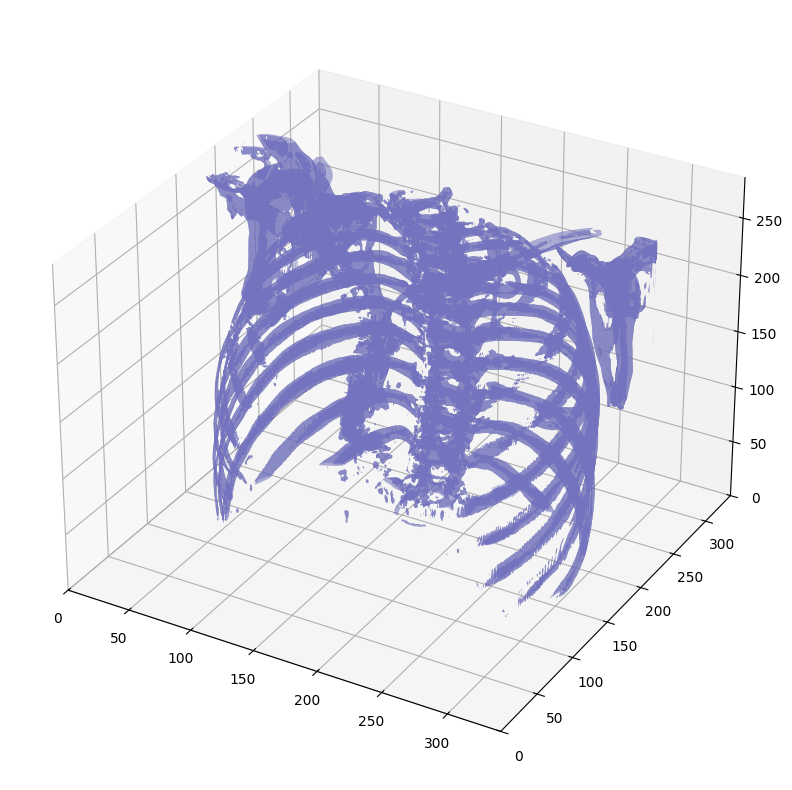

In [10]:
plot_3d(pix_resampled, 400)

## Actividad 1: Prueba otros umbrales (dos umbrales) y muestra los resultados.

### Respuesta:

Usando unidades de Hounsefield intentamos encontrar umbrales interesantes

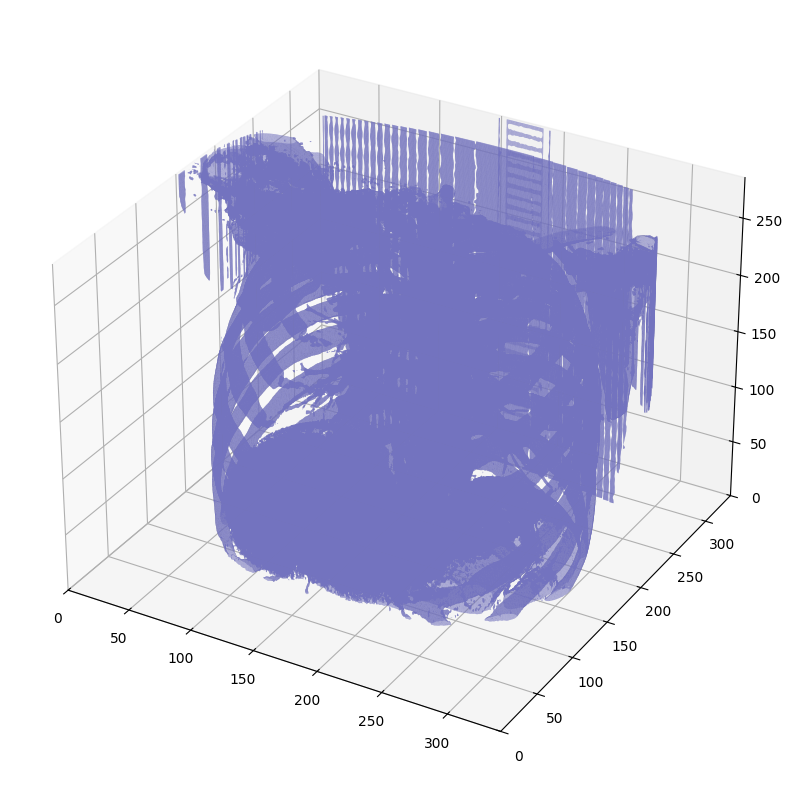

In [80]:
umbral_tejido_blando : float = 100.0 # A partir de aqui se ve tejido blando

plot_3d(pix_resampled, umbral_tejido_blando)

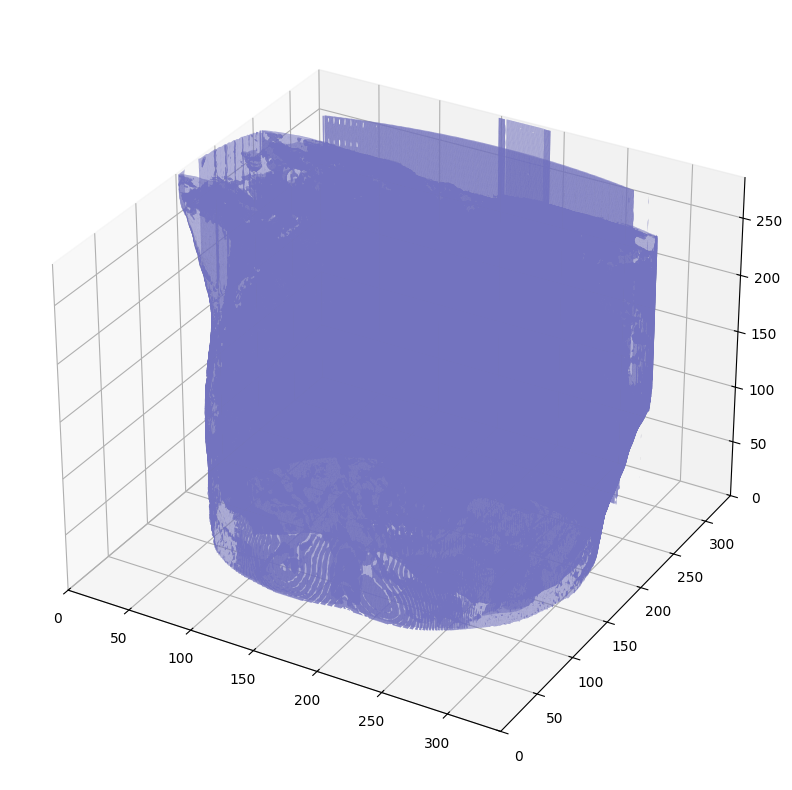

In [82]:
umbral_fino : float = 10.0 # Con este umbral esperamos ver tejidos mas delgados (como piel) y fluidos 

plot_3d(pix_resampled, umbral_fino)